In [1]:
import numpy as np
import matplotlib.pyplot as plt

model_name = "LightWeightModel_ExtraExtraLight_V2_rerun"

train_losses_hist = np.load(f"./output/{model_name}/train_losses_hist.npy")
val_losses_hist = np.load(f"./output/{model_name}/val_losses_hist.npy")
train_r2_hist = np.load(f"./output/{model_name}/train_r2_hist.npy")
val_r2_hist = np.load(f"./output/{model_name}/val_r2_hist.npy")

train_mae_hist = np.load(f"./output/{model_name}/train_mae_hist.npy")
val_mae_hist = np.load(f"./output/{model_name}/val_mae_hist.npy")

In [2]:
min_RMSE_epoch = np.argmin(val_losses_hist)
min_RMSE_value = val_losses_hist[min_RMSE_epoch]
MAE_value_at_min_RMSE = val_mae_hist[min_RMSE_epoch]

print(f"Minimum Validation RMSE: {min_RMSE_value:.4f} at epoch {min_RMSE_epoch+1}")
print(f"Corresponding Validation MAE at this epoch: {MAE_value_at_min_RMSE:.4f}")

Minimum Validation RMSE: 3.6155 at epoch 1381
Corresponding Validation MAE at this epoch: 2.9315


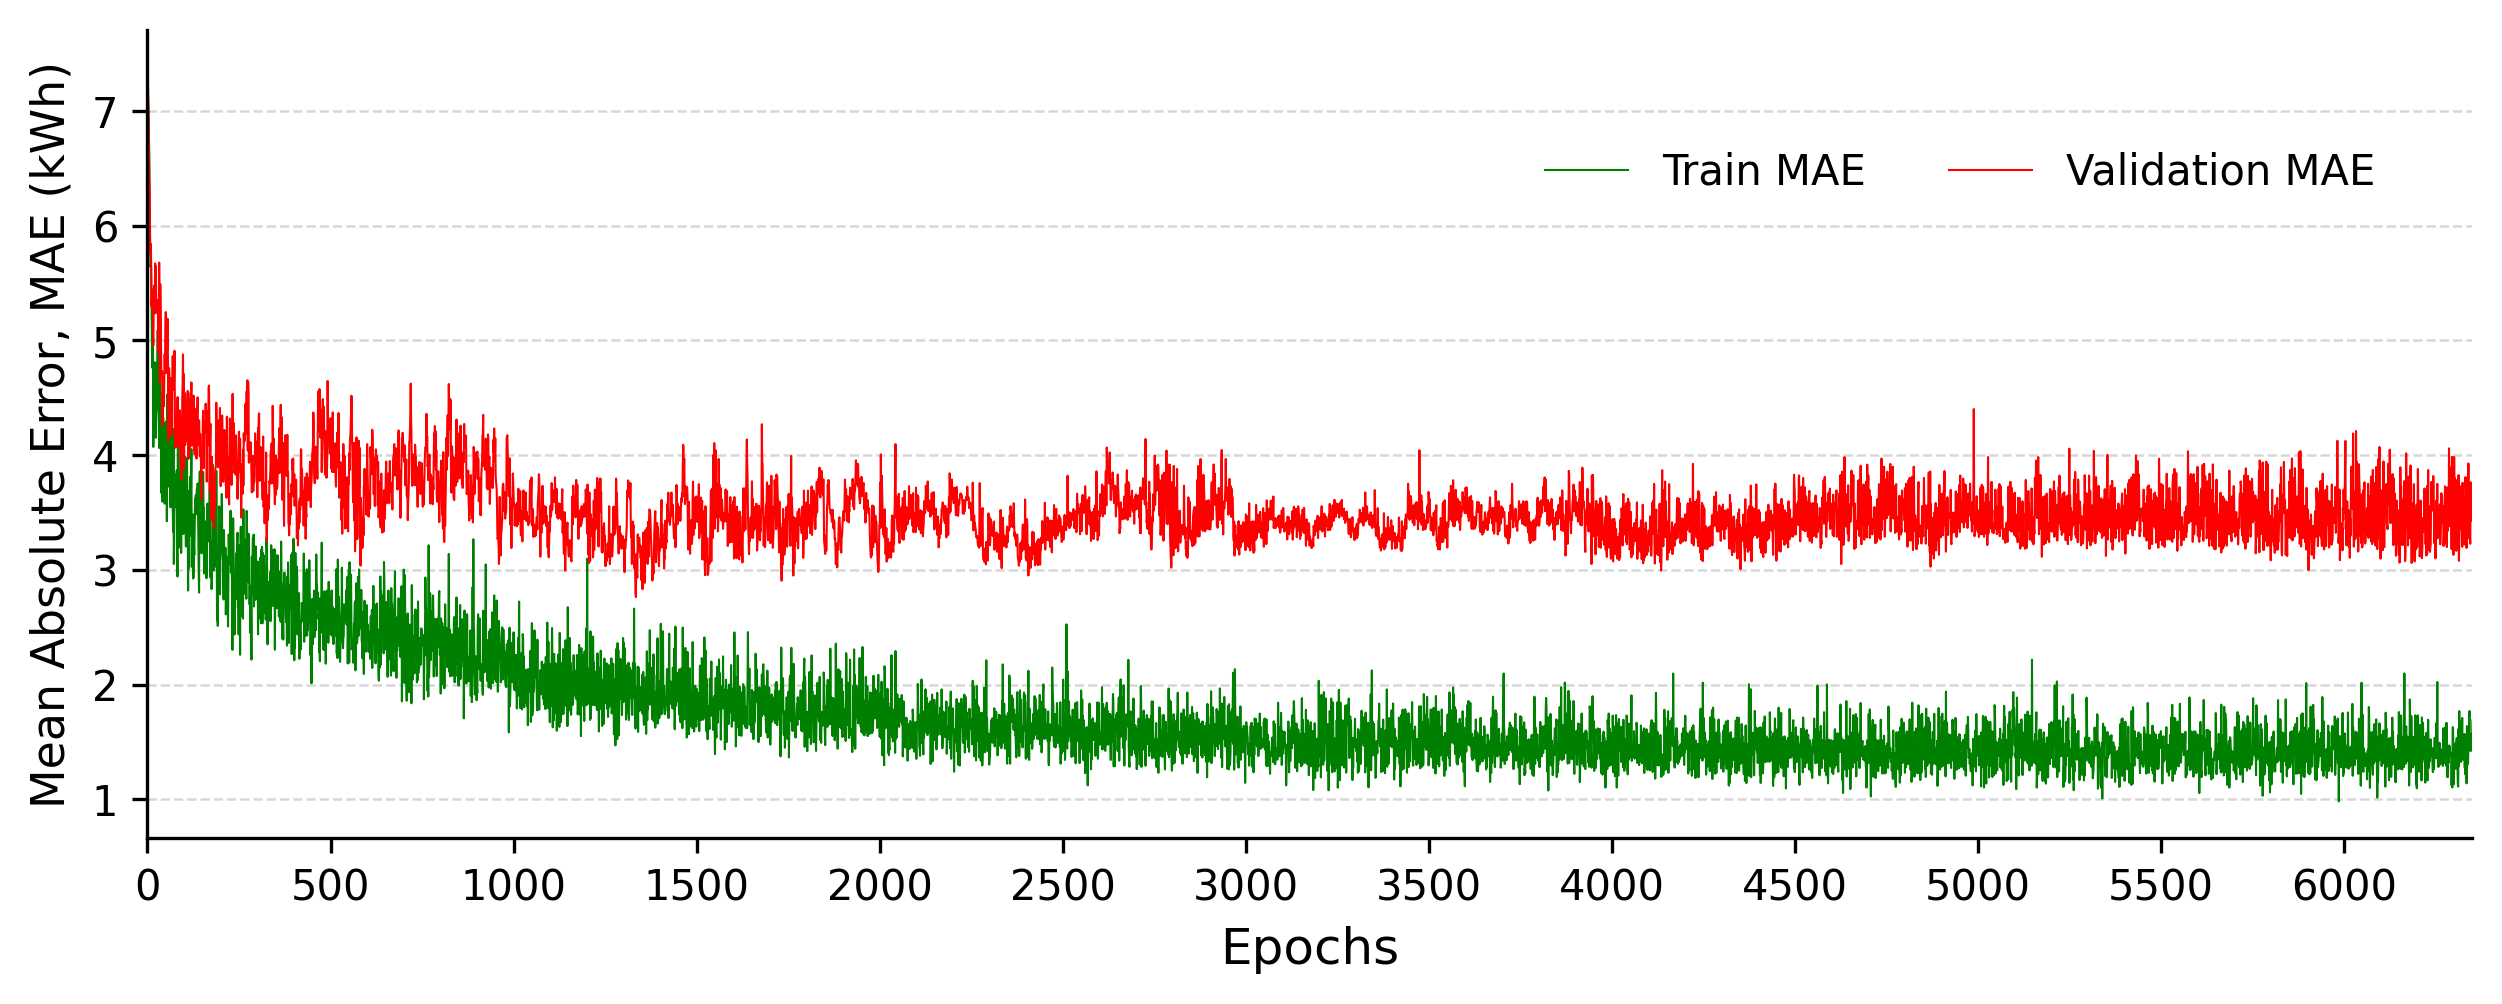

In [3]:

from tkinter import font


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3.5), dpi=300, sharex=True)

ax = axes    # --- Axes styling ---

# ax.plot(train_losses_hist, label='Train RMSE', color='blue', linewidth=0.6)
# ax.plot(val_losses_hist, label='Validation RMSE', color='orange', linewidth=0.6)
        
# ax=axes[1]    # --- Axes styling ---

ax.plot(train_mae_hist, label='Train MAE', color='green', linewidth=0.5)
ax.plot(val_mae_hist, label='Validation MAE', color='red', linewidth=0.5)

# ax.text(1,108,title, fontsize=12,fontweight = 'bold')
ax.set_ylabel('Mean Absolute Error, MAE (kWh)', fontsize=11)
# ax.set_ylim(0, np.max(grid_demand + flow["pv_to_battery"]) * 1.2)
ax.grid(True, axis='y', linestyle='--', linewidth=0.6, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, len(train_losses_hist)-1)
ax.set_xticks(np.arange(0, len(train_losses_hist), 500))

# Shared bottom x-axis label
axes.set_xlabel('Epochs', fontsize=12)

# Shared legend
handles, labels_all = axes.get_legend_handles_labels()
fig.legend(handles, labels_all, loc='upper right', ncol=2, frameon=False, fontsize=10, bbox_to_anchor=(0.88, 0.8))

# plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [4]:
from dataloader.loader import get_loaders_from_files

train_loader, val_loader, test_loader = get_loaders_from_files(
    merged_csv_path="/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/supervised_learning/training_data/merged_windowed_dataset.csv",
    feature_info_path="/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/supervised_learning/training_data/feature_info.json",
    sequence_length=24,
    batch_size=4,
    num_workers=2,
)

✅ Dataset split: 107 train, 23 val, 23 test


In [5]:
def find_battery_index(battery_seq, battery_demand):
    for i in range(battery_demand.shape[0]):
        window = battery_demand[i, 1:]  # 48-hour segment
        for start in range(48 - 24 + 1):
            if np.allclose(window[start:start + 24], battery_seq, atol=1e-5):
                return i, int(battery_demand[i, 0]), start
    raise ValueError("No matching battery window found!")

In [6]:
from models.temporal_attentive_fusion_net_light import TemporalAttentiveFusionNet
import torch
from sklearn.metrics import r2_score
import os
import pandas as pd

def read_clean_csv(path):
        df = pd.read_csv(path, index_col=0)
        df = df.apply(lambda c: c.astype(str).str.replace('"', '').str.strip())
        df = df.apply(pd.to_numeric, errors="coerce")
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df


battery_demand = np.load(os.path.join("/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/battery_series_window48.npy"))  # (N, 25)
building_demand = read_clean_csv(os.path.join("/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/building_data.csv"))
electricity_price = read_clean_csv(os.path.join("/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/electricitycostG2B_data.csv"))
radiation = read_clean_csv(os.path.join("/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/radiation_data.csv"))
temperature = read_clean_csv(os.path.join("/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/temperature_data.csv"))

building_demand.index = pd.to_datetime(building_demand.index)

static_df = pd.DataFrame(index=building_demand.index)
static_df["sin_hour"] = np.sin(2 * np.pi * building_demand.index.hour / 24)
static_df["cos_hour"] = np.cos(2 * np.pi * building_demand.index.hour / 24)
static_df["sin_day"]  = np.sin(2 * np.pi * building_demand.index.dayofweek / 7)
static_df["cos_day"]  = np.cos(2 * np.pi * building_demand.index.dayofweek / 7)

/tmp/ipykernel_2203640/2521841046.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_2203640/2521841046.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_2203640/2521841046.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_2203640/2521841046.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [7]:
import numpy as np
import torch

def match_and_prepare_tensor(
    battery_demand: np.ndarray,
    building_demand: np.ndarray,
    radiation: np.ndarray,
    temperature: np.ndarray,
    price: np.ndarray,
    seq_len: int = 24,
    idx_match: int = 0,
    query_start: int = None,
    device: torch.device = "cpu",
    local_offset: int = 0
):
    """
    Find which 48-hour window in `battery_demand` contains the queried 24-hour window,
    then return the 4 aligned temporal features + battery sequence as a single tensor.
    """
    i_match = idx_match
    win_start = query_start
    # Local offset inside that 48-hour window

    # === Step 3: extract aligned slices ===
    battery_window = battery_demand[i_match, 1 + local_offset : 1 + local_offset + seq_len]
    building_window = building_demand[query_start : query_start + seq_len, 0]
    radiation_window = radiation[query_start : query_start + seq_len, 0]
    temperature_window = temperature[query_start : query_start + seq_len, 0]
    price_window = price[query_start : query_start + seq_len, 0]
    
    row_feats = static_df.iloc[query_start + seq_len - 1, :].tolist()
            # Concatenate all temporal features
    for w in [building_window, radiation_window, temperature_window, price_window, battery_window]:
        row_feats.extend(w.tolist())

    x_tensor = torch.tensor(row_feats, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 24, 5]
    return x_tensor, i_match


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TemporalAttentiveFusionNet().to(DEVICE)

save_path = "/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/supervised_learning/output/LightWeightModel_ExtraExtraLight_V2_rerun/checkpoints/best_model_3.615_r2_0.792.pth"
# === Final Test Evaluation ===
if save_path is not None:
    model.load_state_dict(torch.load(save_path, weights_only=True))
    model.eval()

test_preds, test_labels = [], []

decisions_full = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE).unsqueeze(1)

        x_np = x.cpu().numpy()  # shape (batch, 24, feature_dim)

        for b in range(x_np.shape[0]):
            battery_seq = x_np[b, -24:]  # shape (24,)
            idx_match, start_idx, offset = find_battery_index(battery_seq, battery_demand)
            
            decisions=[idx_match]
            
            print(f"Series: {idx_match}, Index: {start_idx}")
            
            for loop_idx in range(24):
            
                x_tensor, _ = match_and_prepare_tensor(
                    battery_demand,
                    building_demand.values,
                    radiation.values,
                    temperature.values,
                    electricity_price.values,
                    seq_len=24,
                    idx_match=idx_match,
                    query_start=start_idx,
                    device=DEVICE,
                    local_offset=loop_idx
                )
                # print(f"Prepared tensor shape: {x_tensor.shape}")  # should be [1, 24, 5]

                out = model(x_tensor)
                test_preds.extend(out.cpu().numpy())
                test_labels.extend(y.cpu().numpy())
                
                decisions.append(out.cpu().numpy().flatten()[0])
            # print(np.array(decisions))
            
            decisions_full.append(decisions)
            
    decisions_full = np.array(decisions_full).round(2)
    print(decisions_full.sum(axis=1))
                            

# test_r2 = r2_score(test_labels, test_preds)
# test_mae = np.mean(np.abs(np.array(test_labels) - np.array(test_preds)))
# # Compute RMSE on test set
# test_mse = np.mean((np.array(test_labels) - np.array(test_preds))**2)
# test_rmse = np.sqrt(test_mse)
# print(f"\n✅ Test R²: {test_r2:.4f}, MAE: {test_mae:.4f} kWh, RMSE: {test_rmse:.4f} kWh")


Series: 104, Index: 10762
Series: 30, Index: 10688
Series: 2, Index: 10532
Series: 0, Index: 10530
Series: 52, Index: 10710
Series: 40, Index: 10698
Series: 27, Index: 10637
Series: 0, Index: 10530
Series: 0, Index: 10530
Series: 91, Index: 10749
Series: 54, Index: 10712
Series: 31, Index: 10689
Series: 44, Index: 10702
Series: 72, Index: 10730
Series: 132, Index: 10871
Series: 30, Index: 10688
Series: 103, Index: 10761
Series: 45, Index: 10703
Series: 0, Index: 10530
Series: 85, Index: 10743
Series: 132, Index: 10871
Series: 70, Index: 10728
Series: 107, Index: 10765
[ 327.58  136.93 -287.   -229.41   81.05 -150.07   33.92 -229.41 -229.41
  385.81   85.28  190.3  -167.79  108.34   36.33  136.93  221.3  -143.19
 -229.41  324.82   36.33   93.34  453.1 ]


In [ ]:
from calendar import c
import numpy as np
import pandas as pd
from collections import defaultdict
from batteryreader import get_battery_details


# === Load battery data ===
index, available, SOC_a_v, SOC_d_v, t_a_v, t_d_v = get_battery_details(window_length=48)


# ======================================================================
# === Main allocation function =========================================
# ======================================================================

def run_allocation(index, available, t_arr, t_dep, soc_arr, soc_dep, decision):
    """
    Rule-based charging routine with priority ranking.
    SOC[t, v] represents the state-of-charge *before charging* at hour t.
    The decision array modulates net power (positive = charge, negative = discharge).
    Batteries are prioritized by urgency:
        urgency = (SOC_dep - SOC_now) / (t_dep - t_now)
    """

    # === Helper functions ===
    def load_building():
        df = pd.read_csv(
            "/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/building_data.csv",
            index_col="Datetime",
        )
        return df.apply(pd.to_numeric, errors="coerce").values.flatten()

    def load_price():
        df = pd.read_csv(
            "/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/electricitycostG2B_data.csv",
            index_col="Datetime",
        )
        return df.apply(pd.to_numeric, errors="coerce").values.flatten()

    def load_pv():
        rad = pd.read_csv(
            "/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/radiation_data.csv",
            index_col="Datetime",
        )
        tmp = pd.read_csv(
            "/home/lisa4090/Documents/GitHub/V2B_Optimization_with_AI_on_BSS/data/processed/temperature_data.csv",
            index_col="Datetime",
        )
        rad, tmp = rad.apply(pd.to_numeric, errors="coerce"), tmp.apply(pd.to_numeric, errors="coerce")

        efficiency, capacity = 0.20, 500  # 500 m², 20% efficient
        return [
            efficiency * capacity * (r * 0.2778) * (1 - 0.005 * (t - 25))
            for r, t in zip(rad.values.flatten(), tmp.values.flatten())
        ]

    # === Load external data ===
    bldg = load_building()[index: index + 48]
    elec = load_price()[index: index + 48]
    pv = load_pv()[index: index + 48]

    # === Initialize arrays ===
    T, n_veh = 48, len(soc_arr)
    soc_t_v = np.zeros((T + 1, n_veh))  # +1 for final SOC after last hour
    ch_t_v = np.zeros((T, n_veh))
    gd_t = np.zeros(T)
    loss_t = np.zeros(T)

    # Initialize SOCs at arrivals
    for v in range(n_veh):
        soc_t_v[t_arr[v], v] = soc_arr[v]

    # === Main simulation loop ===
    all_scores = []

    for t in range(T):
        total_power = 0
        decision_t = decision[t - 24] if (decision is not False and t >= 24) else None

        # Clip decision within ±14 kW
        if decision_t is not None:
            decision_t = np.clip(decision_t, -14, 14)

        assert -14 <= (decision_t if decision_t is not None else 0) <= 14, \
            f"Decision at t={t} out of bounds: {decision_t}"

        # === Compute urgency scores ===
        scores = []
        urgency_by_timeleft = defaultdict(list)
        trigger_max_charge = False

        for v in range(n_veh):
            if available[v][t] == 0:
                scores.append(-np.inf)
                continue

            soc_now = soc_t_v[t, v]
            target = soc_dep[v]
            hours_left = int(t_dep[v] - t)
            urgency = 1.5 * (target - soc_now) / (hours_left * 0.9)

            scores.append(round(urgency, 3))
            urgency_by_timeleft[hours_left].append(round(urgency, 3))

        all_scores.append(scores)

        # === Predict overload condition ===
        total_required_kw = 28 if decision_t is not None else 0
        ave_per_hour_kW = 0
        # print(urgency_by_timeleft)
        for timeleft, urg_list in urgency_by_timeleft.items():

            total_required_kw += sum(max(0, u) for u in urg_list) 
            ave_per_hour_kW += total_required_kw/timeleft 
            # print(f"t={t}",timeleft, ave_per_hour_kW)

            # Urgent departures
            if ave_per_hour_kW >= 14:
                trigger_max_charge = True
                # print("triggered near-future overload")
                break
            

        # === Determine charging/discharging mode ===
        if trigger_max_charge:
            reverse_score, power_max = True, 14
        elif decision_t is None:
            reverse_score, power_max = True, 14
        elif decision_t >= 0:
            reverse_score, power_max = True, decision_t
        else:
            reverse_score, power_max = False, decision_t

        # === Sort vehicles by priority ===
        sorted_scores = sorted(enumerate(scores), key=lambda x: x[1], reverse=reverse_score)

        # === Apply charging/discharging decisions ===
        for v, urgency in sorted_scores:
            if not (t_arr[v] <= t < t_dep[v]):
                continue

            soc_now = soc_t_v[t, v]
            target = soc_dep[v]
            assert 0.199 <= soc_now <= 0.901, f"Invalid SOC {soc_now:.2f} at t={t}, v={v}"

            avail_discharge = (soc_now - 0.2) * 1.5 * 0.9 if t_dep[v] >= t + 1 else 0
            req_power = (target - soc_now) * 1.5 / 0.9

            charge_power, discharge_power = 0.0, 0.0
            
            if (decision_t is None) or (decision_t >= 0) or (trigger_max_charge):
                # Charging
                charge_power = max(0, min(req_power, power_max - total_power))
                ch_t_v[t, v] = charge_power
                total_power += charge_power
                
            else:
                # Discharging
                discharge_power = min(avail_discharge, max(0.0, -decision_t + total_power))
                ch_t_v[t, v] = -discharge_power
                total_power -= discharge_power
                print("discharging", discharge_power, total_power)

            # Update SOC (considering efficiency)
            if ch_t_v[t, v] >= 0:
                soc_t_v[t + 1, v] = soc_now + (ch_t_v[t, v] / 1.5) * 0.9
            else:
                soc_t_v[t + 1, v] = soc_now + (ch_t_v[t, v] / 1.5) / 0.9
                
        # === Safety checks ===
        assert -14 <= total_power <= 14, f"Total power at t={t} exceeds limit: {total_power}"
        assert all(-1.5 <= ch_t_v[t, v] <= 1.5 for v in range(n_veh)), f"Out of range {ch_t_v[t, v]} at t={t}"

        # === Net grid balance ===
        net_demand = bldg[t] - pv[t] + total_power
        gd_t[t] = max(0, net_demand)
        loss_t[t] = -min(0, net_demand)
        
        

    # === Check SOC target misses ===
    for v in range(n_veh):
        gap = soc_dep[v] - soc_t_v[t_dep[v], v]
        soc_now = soc_t_v[t_dep[v], v]
        if gap > 0.01:
            print(f"[MISS] v={v:3d}, stay={t_dep[v] - t_arr[v]:2d}h, dep{t_dep[v]} gap={gap:.3f}, "
                  f"arrSOC={soc_arr[v]:.2f} leavingSOC={soc_now:.2f} expectedDepSOC={soc_dep[v]:.2f}")

    # === Cost calculation ===
    total_cost = np.sum(gd_t * elec)

    return soc_t_v, ch_t_v, gd_t, loss_t, total_cost, bldg, pv, elec


# ======================================================================
# === Metric computation ===============================================
# ======================================================================

def compute_metrics(gd_t, ch_t_v, bldg, pv, loss_t, elec):
    """
    Compute key derived metrics for one simulation run.
    """
    total_cost = np.sum(gd_t * elec)
    total_building = np.sum(bldg)
    total_charging = np.sum(ch_t_v)
    total_pv = np.sum(pv)

    self_sufficiency = max(0, 1 - (np.sum(gd_t) / (total_building + total_charging)))
    pv_utilization = 1 - (np.sum(loss_t) / total_pv) if total_pv > 0 else 0

    return {
        "total_cost": total_cost,
        "self_sufficiency": self_sufficiency,
        "pv_utilization": pv_utilization,
        "initial_grid": np.maximum(bldg - pv, 0),
        "final_grid": gd_t,
        "charging": np.sum(ch_t_v, axis=1),
        "bldg": bldg,
        "pv": pv,
    }


# ======================================================================
# === Batch runner =====================================================
# ======================================================================

def run_full_batch(decisions_full, index, available, t_a_v, t_d_v, SOC_a_v, SOC_d_v):
    
    """
    Execute allocation runs for both AI-based (decision-driven) and baseline (immediate) strategies.
    Collect results and metrics for comparison.
    """
    results_AI = {
        "initial_grid": [], "final_grid": [], "charging": [], "soc_series": [],
        "total_cost": [], "self_suff": [], "pv_util": []
    }

    results_baseline = {
        "initial_grid": [], "final_grid": [], "charging": [], "soc_series": [],
        "total_cost": [], "self_suff": [], "pv_util": [],
        "bldg": [], "pv": []
    }

    for i, decisionraw in enumerate(decisions_full):
        idx = int(decisionraw[0])
        decision = decisionraw[1:]
        print(f"\n=== Running allocation for series {i}, index {idx} ===")

        # ---------- AI-Controlled (Decision-driven) ----------
        soc_AI, ch_AI, gd_AI, loss_AI, _, bldg, pv, elec = run_allocation(
            index[idx], available[idx],
            t_a_v[idx], t_d_v[idx],
            SOC_a_v[idx], SOC_d_v[idx],
            decision=decision
        )

        metrics_AI = compute_metrics(gd_AI, ch_AI, bldg, pv, loss_AI, elec)

        results_AI["initial_grid"].append(metrics_AI["initial_grid"])
        results_AI["final_grid"].append(metrics_AI["final_grid"])
        results_AI["charging"].append(metrics_AI["charging"])
        results_AI["soc_series"].append(soc_AI)
        results_AI["total_cost"].append(metrics_AI["total_cost"])
        results_AI["self_suff"].append(metrics_AI["self_sufficiency"])
        results_AI["pv_util"].append(metrics_AI["pv_utilization"])

        results_AI["soc_series"].append(soc_AI)

        # ---------- Baseline (Immediate-charging) ----------
        soc_base, ch_base, gd_base, loss_base, _, bldg, pv, elec = run_allocation(
            index[idx], available[idx],
            t_a_v[idx], t_d_v[idx],
            SOC_a_v[idx], SOC_d_v[idx],
            decision=False
        )

        metrics_base = compute_metrics(gd_base, ch_base, bldg, pv, loss_base, elec)

        results_baseline["initial_grid"].append(metrics_base["initial_grid"])
        results_baseline["final_grid"].append(metrics_base["final_grid"])
        results_baseline["charging"].append(metrics_base["charging"])
        results_baseline["soc_series"].append(soc_base)
        results_baseline["total_cost"].append(metrics_base["total_cost"])
        results_baseline["self_suff"].append(metrics_base["self_sufficiency"])
        results_baseline["pv_util"].append(metrics_base["pv_utilization"])
        results_baseline["bldg"].append(bldg)
        results_baseline["pv"].append(pv)


        results_baseline["soc_series"].append(soc_base)
        results_baseline["bldg"].append(bldg)
        results_baseline["pv"].append(pv)


    return results_AI, results_baseline


# ======================================================================
# === Execute batch ====================================================
# ======================================================================

results_AI, results_base = run_full_batch(decisions_full, index, available, t_a_v, t_d_v, SOC_a_v, SOC_d_v)



=== Running allocation for series 0, index 104 ===
10762

=== Running allocation for series 1, index 30 ===
10688

=== Running allocation for series 2, index 2 ===
10532
discharging 0.9449999999999998 -0.9449999999999998
discharging 0.9450000000000003 -1.8900000000000001
discharging 0.9450000000000003 -2.8350000000000004
discharging 0.9450000000000003 -3.7800000000000007
discharging 0.9450000000000003 -4.725000000000001
discharging 0.9450000000000003 -5.670000000000002
discharging 0.9450000000000003 -6.615000000000002
discharging 0.9449999999999998 -7.560000000000002
discharging 0.9450000000000003 -8.505000000000003
discharging 0.7155 -9.220500000000003
discharging 0.7425 -9.963000000000003
discharging 0.6345000000000001 -10.597500000000004
discharging 0.6480000000000001 -11.245500000000003
discharging 0.7020000000000001 -11.947500000000003
discharging 0.042499999999996874 -11.99
discharging 0.0 -11.99
discharging 0.0 -11.99
discharging 0.0 -11.99
discharging 0.0 -11.99
discharging 0.

In [71]:
print(np.array([results_AI["final_grid"][i][24:].sum() for i in range(len(results_AI["final_grid"]))]).sum() ) 
      
print(np.array([results_base["final_grid"][i][24:].sum() for i in range(len(results_base["final_grid"]))]).sum() ) 

print(np.array([results_AI["charging"][i][24:].sum() for i in range(len(results_AI["charging"]))]).sum() ) 
      
print(np.array([results_base["charging"][i][24:].sum() for i in range(len(results_base["charging"]))]).sum() ) 



12521.474117224692
12504.352759200001
706.0380246913579
688.9166666666666


In [94]:
np.array(results_AI["final_grid"][0]).shape

(48,)

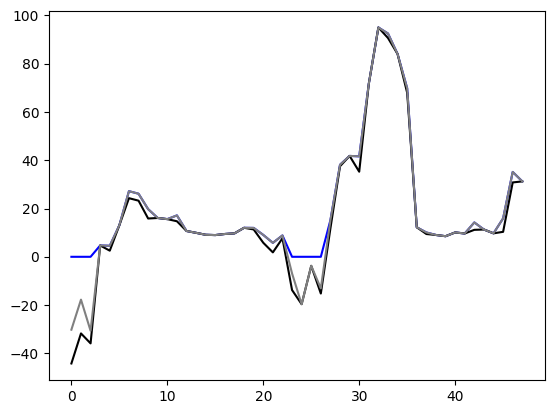

In [106]:
plt.plot(np.array(results_AI["final_grid"][0]), label="AI Final Grid", color = 'blue')
plt.plot(np.array(results_base["bldg"][0]-results_base["pv"][0]), label="AI Final Grid", color = 'black')
# plt.plot(np.array(results_base["pv"][0]), label="AI Final Grid")
plt.plot(np.array(results_base["bldg"][0]-results_base["pv"][0]+results_AI["charging"][0]), label="AI Final Grid", color = 'gray')


In [22]:
print(np.array([results_AI["final_grid"][i][:].sum() for i in range(len(results_AI["final_grid"]))]).sum()) 

print(np.array([results_base["final_grid"][i][:].sum() for i in range(len(results_base["final_grid"]))]).sum()) 

print(np.array([results_AI["charging"][i][:].sum() for i in range(len(results_AI["charging"]))]).sum()) 
      
print(np.array([results_base["charging"][i][:].sum() for i in range(len(results_base["charging"]))]).sum()) 

23349.164532891362
23332.043174866667
2230.1213580246913
2213.0000000000005


In [88]:
np.array(results_base["charging"]).shape

(23, 48)

Random index: 7


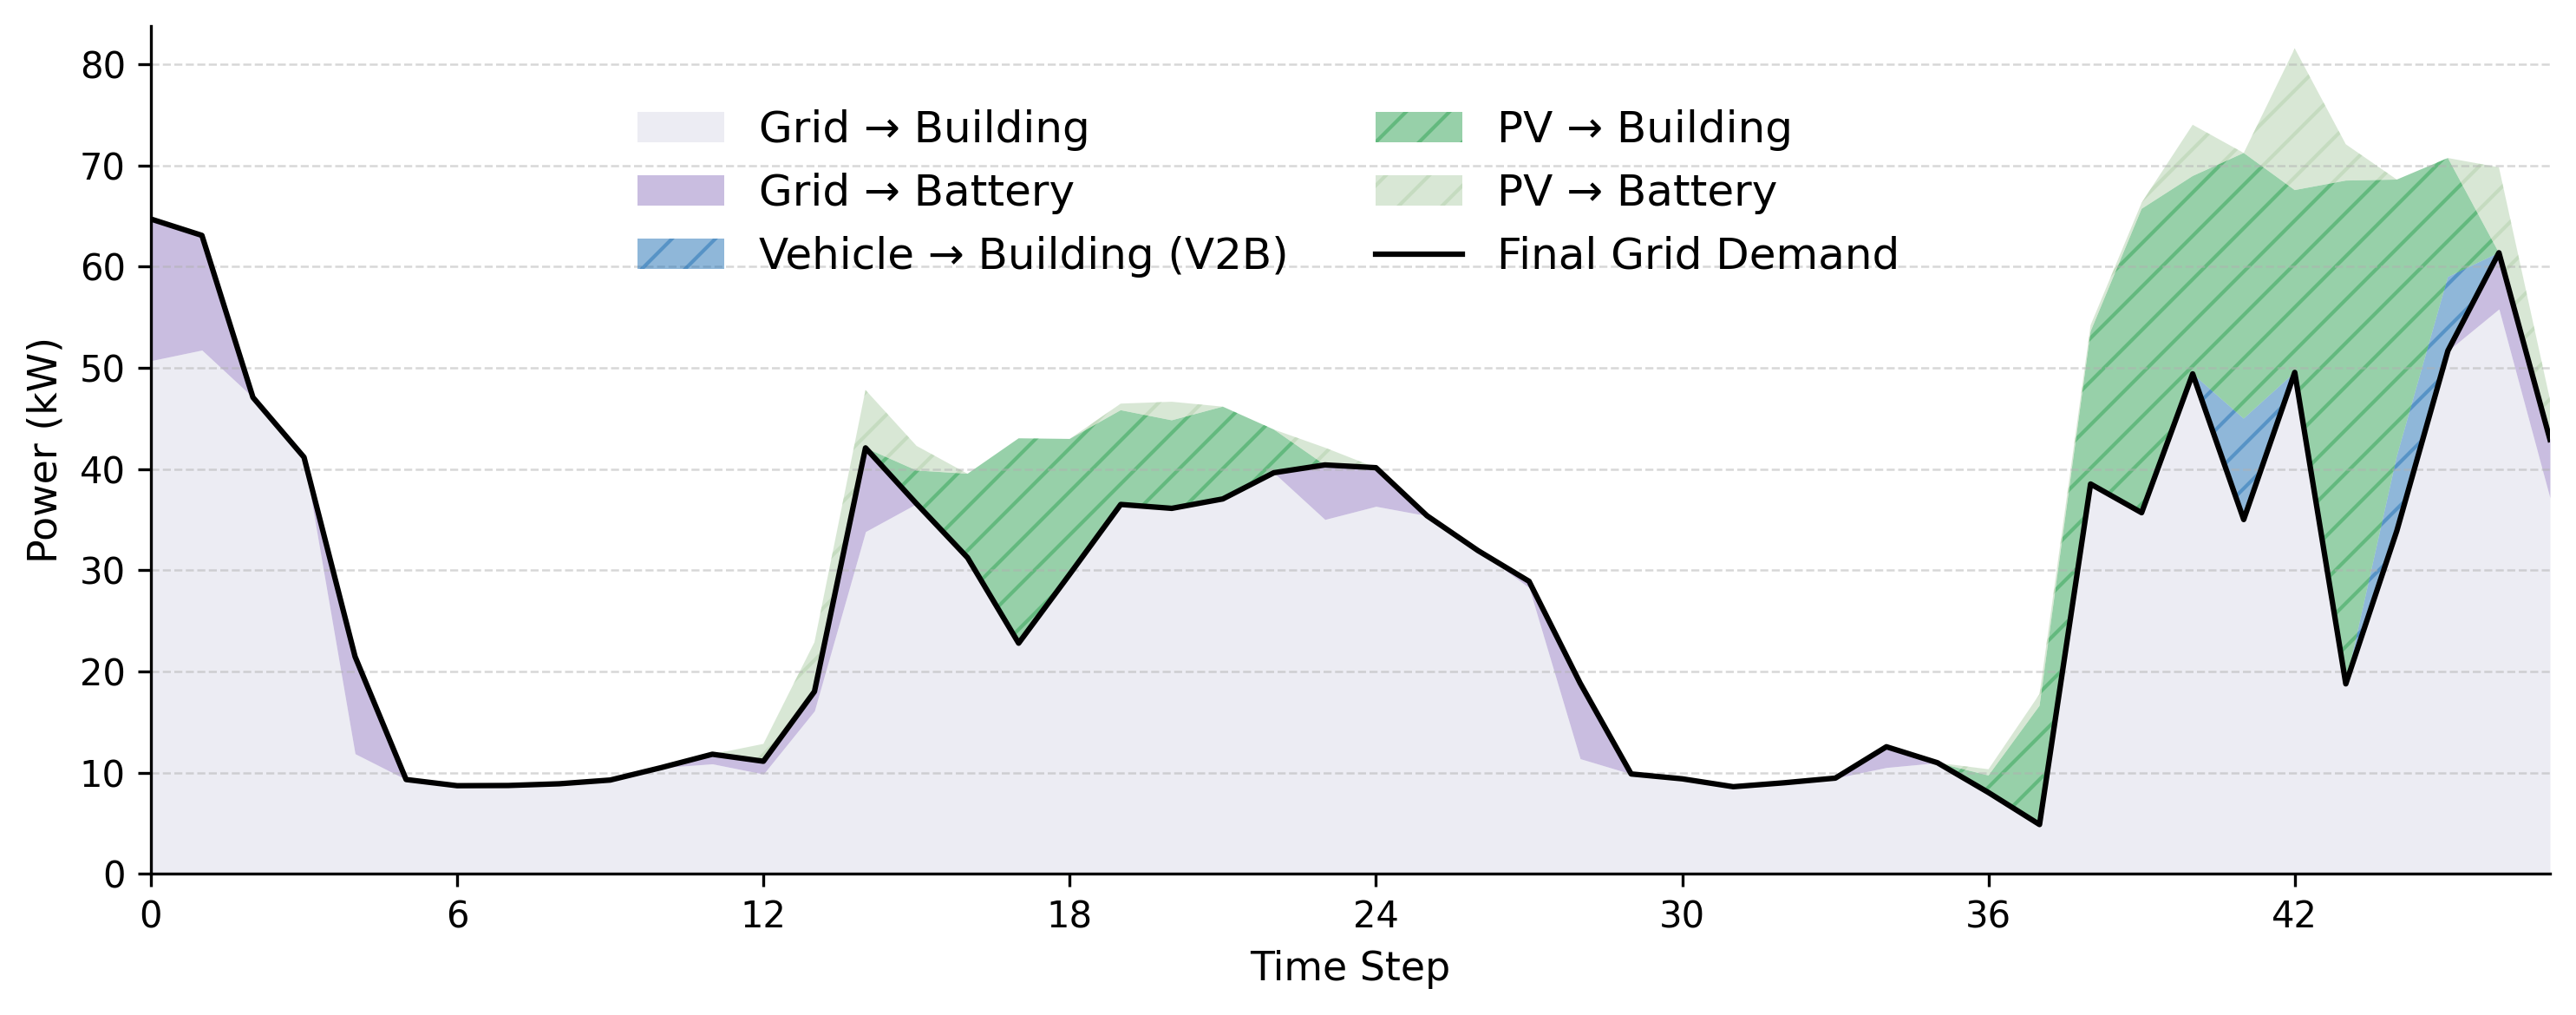

In [128]:
import numpy as np
from matplotlib import pyplot as plt
import random

# =============================
# 1. Base Data Extraction
# =============================
charging_demands = results_AI["charging"]
final_grid_demands = results_AI["final_grid"]
initial_grid_demands = results_AI["initial_grid"]

pv_generations_immediate = results_base["pv"]
building_energy_demands_immediate = results_base["bldg"]

# random_idx = random.randint(0, len(charging_demands) - 1)
random_idx = 7
print("Random index:", random_idx)

selected_charging = charging_demands[random_idx]
selected_grid_final = final_grid_demands[random_idx]
selected_pv = pv_generations_immediate[random_idx]
selected_building = building_energy_demands_immediate[random_idx]

# =============================
# 2. Separate Positive/Negative Charging
# =============================
discharging_demands = np.array([v if v < 0 else 0 for v in selected_charging])
charging_only_demands = np.array([v if v > 0 else 0 for v in selected_charging])

time_steps = np.arange(len(selected_charging))

# =============================
# 3. Energy Flow Computation Function
# =============================
def compute_flows(selected_grid, charging_only, discharging, pv, building):
    """Compute energy flow components for one scenario."""
    vehicle_to_building = -discharging                            # 1. Discharging to building
    pv_to_battery = np.minimum(pv, charging_only)                  # 2. PV → battery first
    pv_to_building = np.maximum(pv - pv_to_battery, 0)             # 3. Remaining PV → building
    grid_to_battery = np.maximum(selected_grid - building, 0)      # 4. Grid → battery
    grid_to_building = np.maximum(selected_grid - grid_to_battery, 0)   # 5. Remaining grid → building
    return {
        "vehicle_to_building": vehicle_to_building,
        "pv_to_battery": pv_to_battery,
        "pv_to_building": pv_to_building,
        "grid_to_battery": grid_to_battery,
        "grid_to_building": grid_to_building
    }

flows_final = compute_flows(selected_grid_final, charging_only_demands, discharging_demands, selected_pv, selected_building)

# =============================
# 4. Plot Configuration
# =============================
labels = [
    "Grid → Building",
    "Grid → Battery",
    "Vehicle → Building (V2B)",
    "PV → Building",
    "PV → Battery"
]

colors = [
    "#e8e8f0",  # Grid → Building
    "#b2a2d4",  # Grid → Battery
    "#2171b5",  # Vehicle → Building
    "#31a354",  # PV → Building
    "#b3d1ac"   # PV → Battery
]

hatches = [None, None, "//", "//", "//"]

# =============================
# 5. Plotting
# =============================
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

title = "a) Base Scenario: Immediate Charging"
flow = flows_final
grid_demand = selected_grid_final

cumulative = np.zeros_like(time_steps, dtype=float)

# --- 1. Grid → Building ---
ax.fill_between(time_steps, cumulative, cumulative + flow["grid_to_building"],
                color=colors[0], alpha=0.8, label=labels[0], linewidth=0)
cumulative += flow["grid_to_building"]

# --- 2. Grid → Battery ---
ax.fill_between(time_steps, cumulative, cumulative + flow["grid_to_battery"],
                color=colors[1], alpha=0.7, label=labels[1], linewidth=0)
cumulative += flow["grid_to_battery"]

# --- 3. Vehicle → Building (Discharging) ---
ax.fill_between(time_steps, grid_demand, grid_demand + flow["vehicle_to_building"],
                color=colors[2], alpha=0.5, hatch=hatches[2], label=labels[2], linewidth=0)

# --- 4. PV → Building ---
ax.fill_between(time_steps,
                grid_demand + flow["vehicle_to_building"],
                grid_demand + flow["vehicle_to_building"] + flow["pv_to_building"],
                color=colors[3], alpha=0.5, hatch=hatches[3], label=labels[3], linewidth=0)

# --- 5. PV → Battery ---
ax.fill_between(time_steps,
                grid_demand + flow["vehicle_to_building"] + flow["pv_to_building"],
                grid_demand + flow["vehicle_to_building"] + flow["pv_to_building"] + flow["pv_to_battery"],
                color=colors[4], alpha=0.5, hatch=hatches[4], label=labels[4], linewidth=0)

# --- Plot total grid demand & building load ---
ax.plot(grid_demand, color='black', linewidth=1.5, label='Final Grid Demand')
# ax.plot(selected_building, color='orange', linewidth=1.2, linestyle='--', label='Building Load')

# --- Axes styling ---
# ax.set_title(title, fontsize=12, fontweight='bold', loc='left')
ax.set_ylabel('Power (kW)', fontsize=11)
ax.set_xlabel('Time Step', fontsize=11)
ax.set_xticks(np.arange(0, len(time_steps)+1, 6))
ax.grid(True, axis='y', linestyle='--', linewidth=0.6, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, len(time_steps)-1)
ax.set_ylim(0, np.max(grid_demand + flow["pv_to_battery"]) * 1.2)

# --- Legend ---
handles, labels_all = ax.get_legend_handles_labels()
fig.legend(handles, labels_all, loc='upper right', ncol=2, frameon=False, fontsize=12, bbox_to_anchor=(0.75, 0.92))

plt.tight_layout()
plt.show()
